In [2]:
import matplotlib.pyplot as plt
import numpy as np

Image shape: (557, 693, 3)
Image range: (0.0, 1.0)


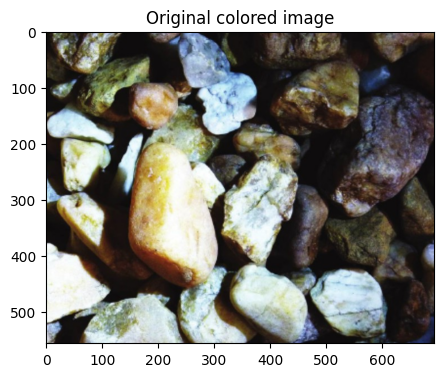

In [117]:
# Import rock image
IMG_FILENAME = 'colorful_rocks2.png'

# Plot image
IMG = plt.imread(IMG_FILENAME)

# Check shape and range
print(f'Image shape: {IMG.shape}')
print(f'Image range: {IMG.min(), IMG.max()}')

plt.figure(figsize=(5,5))
plt.imshow(IMG)
plt.title('Original colored image')
plt.show()

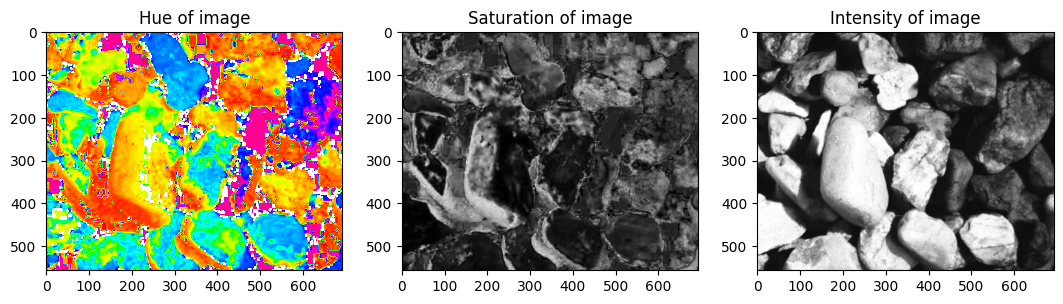

In [126]:
# Scale image to 0-255
IMG_255 = np.round(IMG * 255)

# Convert image to HSV format
# RGB to HSV
def RGB2HSV(RGB_IMG):
    R, G, B = RGB_IMG[:,:,0], RGB_IMG[:,:,1], RGB_IMG[:,:,2]
    R, G, B = R/255, G/255, B/255

    V = np.maximum.reduce([R, G, B])
    C = V - np.minimum.reduce([R, G, B])
    S = C / V

    # Compute H
    H = np.zeros_like(V)
    mask = (C != 0)  # avoid division by zero
    
    # Assign based on which channel is the max
    with np.errstate(invalid='ignore', divide='ignore'):
        H_R = ((G - B) / C) % 6
        H_G = ((B - R) / C) + 2
        H_B = ((R - G) / C) + 4

    H = np.where((V == R) & mask, H_R, H)
    H = np.where((V == G) & mask, H_G, H)
    H = np.where((V == B) & mask, H_B, H)
    
    # Handle undefined hue (C == 0)
    H[~mask] = np.nan

    # Rescale
    H *= 60
    S *= 255
    V *= 255

    # Shape to be (x,y,3)... just like input
    HSV_IMG = np.stack((H, S, V), axis=-1)
    
    return HSV_IMG

IMG_HSV = RGB2HSV(IMG_255)

# PLot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(13,9))

ax0.imshow(IMG_HSV[:,:,0], vmin=0, vmax=360, cmap='hsv')
ax0.set_title('Hue of image')

ax1.imshow(IMG_HSV[:,:,1], vmin=0, vmax=255, cmap='grey')
ax1.set_title('Saturation of image')

ax2.imshow(IMG_HSV[:,:,2], vmin=0, vmax=255, cmap='grey')
ax2.set_title('Intensity of image')

plt.show()

In [164]:
# Histogram of flattenned arr
def histogram(arr):
    hist = np.zeros(256)
    for px in arr:
        i = round(px)
        hist[i] += 1
    return hist

In [165]:
# Convert flattened img to CDF
def getCDF(arr, normalize=True):
    # Histogram
    hist = histogram(arr)
    
    # CDF
    CDF = np.zeros(256)
    for i, value in enumerate(CDF):
        if i == 0:
            CDF[i] = hist[i]
        else:
            CDF[i] = np.sum(hist[:i+1])

    # Normalize to 1
    if normalize == True:
        CDF /= CDF.max()

    return CDF

In [166]:
# Histogram equalization
def equalize_V(V):
    # Create histogram and cdf
    hist = histogram(V.flatten())
    # Un-normalized CDF
    cdf = getCDF(V.flatten(), normalize=True)

    # Equalize each value of k -> f(k)
    equalize_lut = np.around(255 * cdf).astype(np.uint8)

    V_eq = equalize_lut[V.astype(int)]
    return V_eq

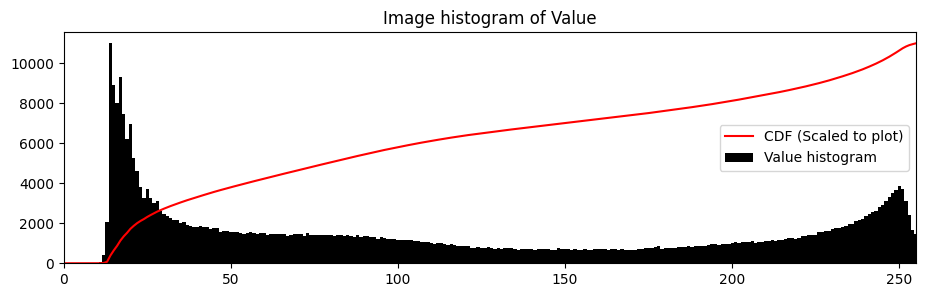

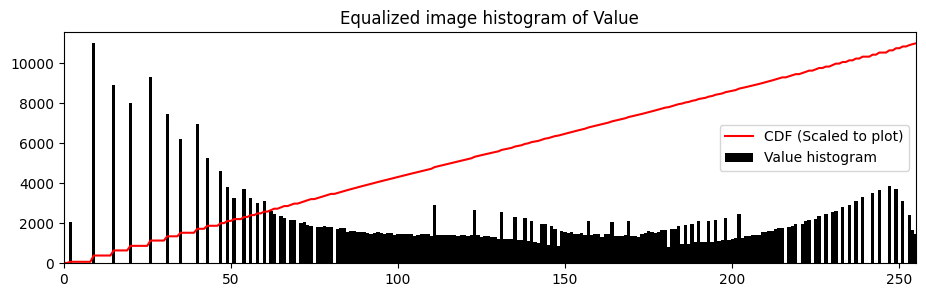

In [167]:
# Histogram of VALUE and CDF
IMG_V = IMG_HSV[:,:,2]

# Image histogram (manual algorithm)
value = range(256)
hist1 = histogram(IMG_V.flatten())
# CDF
CDF1 = getCDF(IMG_V.flatten())

plt.figure(figsize=(11,3))
plt.bar(value, hist1, width=1, color='black', label='Value histogram')
plt.plot(value, CDF1 * hist.max(), color='red', label='CDF (Scaled to plot)')
plt.xlim(0,255)
plt.legend()
plt.title('Image histogram of Value')
plt.show()

# Equalize V image
V_eq = equalize_V(IMG_V)

# Image histogram and CDF and plot!
hist2 = histogram(V_eq.flatten())
CDF2 = getCDF(V_eq.flatten())

plt.figure(figsize=(11,3))
plt.bar(value, hist2, width=1, color='black', label='Value histogram')
plt.plot(value, CDF2 * hist.max(), color='red', label='CDF (Scaled to plot)')
plt.xlim(0,255)
plt.legend()
plt.title('Equalized image histogram of Value')
plt.show()

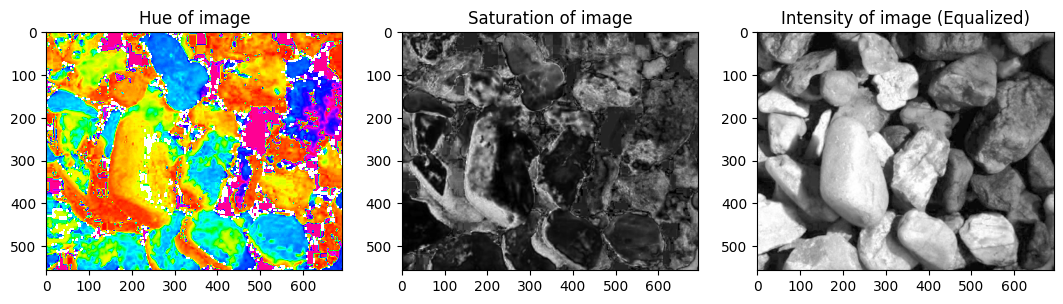

In [168]:
# Plot value of equalized image
IMG_HSV_eq = IMG_HSV.copy()
IMG_HSV_eq[:,:,2] = V_eq

# PLot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(13,9))

ax0.imshow(IMG_HSV_eq[:,:,0], vmin=0, vmax=360, cmap='hsv')
ax0.set_title('Hue of image')

ax1.imshow(IMG_HSV_eq[:,:,1], vmin=0, vmax=255, cmap='grey')
ax1.set_title('Saturation of image')

ax2.imshow(IMG_HSV_eq[:,:,2], vmin=0, vmax=255, cmap='grey')
ax2.set_title('Intensity of image (Equalized)')

plt.show()

In [190]:
# HSV to RGB (https://scratch.mit.edu/discuss/topic/694772/)
def HSV2RGB(HSV_IMG):
    H, S, V = HSV_IMG[:,:,0], HSV_IMG[:,:,1], HSV_IMG[:,:,2]
    S, V = S/255, V/255

    # Intermediate values
    H_ = H / 60
    C = V * S
    X = C * (1 - np.abs((H_) % 2 - 1))
    m = V - C

    # Compute RGB
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)

    # Masks for each sector
    mask0 = (0 <= H_) & (H_ < 1)
    mask1 = (1 <= H_) & (H_ < 2)
    mask2 = (2 <= H_) & (H_ < 3)
    mask3 = (3 <= H_) & (H_ < 4)
    mask4 = (4 <= H_) & (H_ < 5)
    mask5 = (5 <= H_) & (H_ < 6)

    # Compute RGB for each mask
    R[mask0], G[mask0], B[mask0] = C[mask0], X[mask0], 0
    R[mask1], G[mask1], B[mask1] = X[mask1], C[mask1], 0
    R[mask2], G[mask2], B[mask2] = 0, C[mask2], X[mask2]
    R[mask3], G[mask3], B[mask3] = 0, X[mask3], C[mask3]
    R[mask4], G[mask4], B[mask4] = X[mask4], 0, C[mask4]
    R[mask5], G[mask5], B[mask5] = C[mask5], 0, X[mask5]
    
    R, G, B = 255*(R+m), 255*(G+m), 255*(B+m)
    R, G, B = np.uint8(R), np.uint8(G), np.uint8(B) 

    # Shape to be (x,y,3)... just like input
    RGB_IMG = np.stack((R, G, B), axis=-1)
    
    return RGB_IMG

[47 40 21]


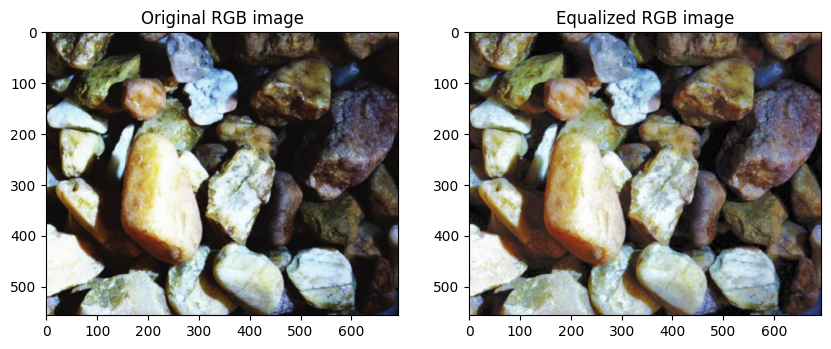

In [191]:
# Convert HSV to RBG
IMG_RGB_eq = HSV2RGB(IMG_HSV_eq)

print(IMG_RGB_eq[5,5,:])
# Plot image BEFORE AND AFTER!
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,6))

ax0.imshow(IMG)
ax0.set_title('Original RGB image')

ax1.imshow(IMG_RGB_eq)
ax1.set_title('Equalized RGB image')

plt.show()